# Assignment 2 - Overfitting, Ridge and Lasso Regression

### Due: Wednesday, April 18th, 11:59 pm on Canvas.

In this notebook, we will run ridge regression multiple times with different L2 penalties to see which one produces the best fit. We will revisit the example of polynomial regression as a means to see the effect of L2 regularization. We will also use LASSO to select features.

In particular, we will:
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression
* Use matplotlib to visualize polynomial regressions
* Use a pre-built implementation of regression (Turi Create) to run polynomial regression, this time with L2 penalty
* Use matplotlib to visualize polynomial regressions under L2 regularization
* Run LASSO with different L1 penalties.
* Choose best L1 penalty using a validation set.

We will continue to use the House data from previous notebooks.

Copyright ©2018 Emily Fox.  All rights reserved.  Permission is hereby granted to students registered for University of Washington CSE/STAT 416 for use solely during Spring Quarter 2018 for purposes of the course.  No other use, copying, distribution, or modification is permitted without prior written consent. Copyrights for third-party components of this work must be honored.  Instructors interested in reusing these course materials should contact the author.

In [16]:
import turicreate as tc
import numpy as np # Has some really cool mathematical functions that we can use

In [17]:
sales, _ = tc.SFrame('/data/home_data.gl').random_split(0.005, seed=0) # We are going to load in roughly 100 samples.
sales

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
6619910140,2015-02-24 00:00:00+00:00,630000,4,1.75,2950,9025,1.0,0
7171200445,2015-02-28 00:00:00+00:00,550700,2,1.0,1010,5000,1.5,0
3422059208,2015-05-11 00:00:00+00:00,390000,3,2.5,1930,64904,1.0,0
7849202231,2014-07-23 00:00:00+00:00,337000,3,2.5,1470,3976,2.0,0
8113101670,2014-12-03 00:00:00+00:00,378000,4,1.5,2140,7920,1.0,0
5104511040,2015-02-20 00:00:00+00:00,380000,4,2.5,2000,6921,2.0,0
8079030350,2014-09-10 00:00:00+00:00,441500,3,2.5,2420,9592,2.0,0
2538400060,2014-06-12 00:00:00+00:00,860000,4,3.25,3960,7012,2.0,0
3679401110,2014-05-30 00:00:00+00:00,332000,2,1.0,1000,4776,1.0,0
4045500625,2014-08-22 00:00:00+00:00,935000,3,3.25,3710,38509,2.0,0


## Revisiting Polynomial Regression


The function below takes in a feature column, and a degree, and returns an SFrame with columns containing the powers of a given input.

In [18]:
def polynomial_sframe(feature, degree):
    poly_sframe = tc.SFrame()
    poly_sframe['power_1'] = feature
    if degree > 1:
        for power in range(2, degree+1): 
            name = 'power_' + str(power)
            poly_sframe[name] = feature.apply(lambda x : x**power)
    return poly_sframe

Let's import pyplot to let us visualize some graphs

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

For plotting purposes (connecting the dots), you'll need to sort by the values of sqft_living. For houses with identical square footage, we break the tie by their prices.

In [20]:
sales = sales.sort(['sqft_living','price'])


### Q1) Generate polynomial features up to degree 15 using polynomial_sframe() and fit a linear regression model with these features. When fitting the model, use an L2 penalty of 1e-5. What's the learned value for the coefficient of feature`power_1`?

Note: When we have so many features and so few data points, the solution can become highly numerically unstable, which can sometimes lead to strange unpredictable results. Thus, rather than using no regularization, we will introduce a tiny amount of regularization (l2_penalty=1e-5) to make the solution numerically stable.

With the L2 penalty specified below, fit the model and print out the learned weights.

**Hints:** 
* Make sure to add `'price'` column to the new SFrame before calling `tc.linear_regression.create()`.
* Also, make sure Turi Create doesn't create its own validation set by using the option `validation_set=None` in this call.

You can view the coefficients of the learned model by looking at `.coefficients` field on the learned model.

In [21]:
l2_small_penalty= 1e-5

In [22]:
poly15_data = polynomial_sframe(sales['sqft_living'], 15)
my_features = poly15_data.column_names()
poly15_data['price'] = sales['price']

model15 = tc.linear_regression.create(poly15_data, target = 'price', features = my_features, l2_penalty = l2_small_penalty, validation_set = None)
coefs = model15.coefficients
coefs.print_rows(num_rows = 16)


# my_features = poly15_data.column_names()
# poly15_data['price'] = ...

# model15 = tc.linear_regression.create(...)

# coefs = model15.coefficients
# coefs.print_rows(num_rows = 16)

Linear regression:

--------------------------------------------------------

Number of examples          : 93

+-------------+-------+--------------------+--------+
|     name    | index |       value        | stderr |
+-------------+-------+--------------------+--------+
| (intercept) |  None |   202996.419344    |  nan   |
|   power_1   |  None |   -180.535162219   |  nan   |
|   power_2   |  None |   0.476052249772   |  nan   |
|   power_3   |  None | -0.000162587521049 |  nan   |
|   power_4   |  None | -3.34371247319e-08 |  nan   |
|   power_5   |  None | 9.17788253931e-12  |  nan   |
|   power_6   |  None | 4.53678817633e-15  |  nan   |
|   power_7   |  None | 5.85613079358e-19  |  nan   |
|   power_8   |  None | -1.45518726115e-22 |  nan   |
|   power_9   |  None | -9.10109195367e-26 |  nan   |
|   power_10  |  None | -2.14806703567e-29 |  nan   |
|   power_11  |  None | -1.18685348349e-33 |  nan   |
|   power_12  |  None | 1.12820625722e-36  |  nan   |
|   power_13  |  None | 4.90864215222e-40  |  nan   |
|   power_14  |  None |  7.329024604e-44   |  nan   |
|   power_15  |  None | -3.2

Number of features          : 15

Number of unpacked features : 15

## Observe Overfitting

Recall from lecture that the polynomial fit of a high degree changed wildly whenever the data changed. We will demonstrate this by splitting the sales data into four subsets and fit the model of degree 15; in lecture we saw that when we have small datasets that these high degree polynomial models tend to overfit the dataset. 

First, split the data into split the sales data into four subsets of roughly equal size and call them `set_1`, `set_2`, `set_3`, and `set_4`. Use `.random_split` function and make sure you set `seed=0`. 

In [23]:
(semi_split1, semi_split2) = sales.random_split(.5,seed=0)
(set_1, set_2) = semi_split1.random_split(0.5, seed=0)
(set_3, set_4) = semi_split2.random_split(0.5, seed=0)

data_subsets = [set_1, set_2, set_3, set_4]

Number of coefficients    : 16

Starting Newton Method

***TODO:***

Write a function `train_model_on_subsets` (below) that will take in an L2 penalty as input and, 
 1. will generate polynomial features up to degree 15 on the 'sqft_living' input for each subset of the data set,
 2. then train a linear regression model with the L2 penalty, and
 3. plot a graph of the `power_1` feature vs 'price' with the data points and the model fits, and
 4. prints out the smallest and largest coefficients for the `power_1` feature over the different models.

We have provided the code for plotting.

**Hints:**
* Set `l1_penalty=0`, so that we don't introduce an L1 penalty as well. 
* When calling `tc.linear_regression.create()`, make sure Turi Create doesn't create its own validation set by using the option `validation_set = None` in this call.
* You can get the `value` of a the coefficient at the `i`th index by calling `coefs[i]['value']`.
* Remember to include the `'price'` column like we had to earlier
* The beginning of Question 1 might be a helpful place to start

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`. 

In [24]:
# TODO:

def train_model_on_subsets(l2_penalty):
    learned_models = []
    model_coefficients = [] #???

    for subset in data_subsets:
        currentData = polynomial_sframe(subset['sqft_living'], 15)
        currentFeatures = currentData.column_names()
        currentData['price'] = subset['price']
        modelTrained = tc.linear_regression.create(currentData, target = 'price', features = currentFeatures, validation_set = None, l1_penalty = 0, l2_penalty = l2_penalty, verbose = False)
        learned_models.append(modelTrained)
        model_coefficients.append(modelTrained.coefficients[1]['value'])
        


    plt.plot(poly15_data['power_1'],poly15_data['price'],'.')

    for model15 in learned_models:
        plt.plot(poly15_data['power_1'], model15.predict(poly15_data),'-')
        
    print "The min power_1 coeff is:", min(model_coefficients), "; And the max power_1 coeff is:", max(model_coefficients)

    

--------------------------------------------------------

+-----------+----------+--------------+--------------------+---------------+

| Iteration | Passes   | Elapsed Time | Training-max_error | Training-rmse |

+-----------+----------+--------------+--------------------+---------------+

### Q2) Use the function that you wrote to train a polynomial regression model on the subsets with the `l2_small_penalty`. Take a look at the plot of the resulting model. For the models learned in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`? 
(For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

### Q3) Do these models have high bias or high variance?
a) High Bias  
b) High Variance


| 1         | 2        | 0.001585     | 695432.790948      | 183579.048109 |

+-----------+----------+--------------+--------------------+---------------+

SUCCESS: Optimal solution found.

The min power_1 coeff is: -2319.61526772 ; And the max power_1 coeff is: 3632.86029603


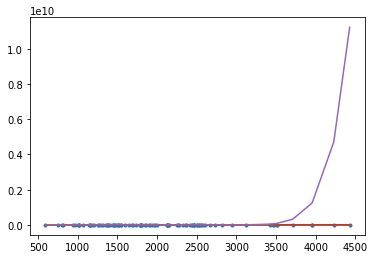

In [25]:
train_model_on_subsets(l2_small_penalty)

## Ridge Regression comes to the rescue

Generally, whenever we see weights change so much in response to change in data, we believe the variance of our estimate to be large. Ridge regression aims to address this issue by penalizing "large" weights. (Weights of `model15` looked quite small, but they are not that small because 'sqft_living' input is in the order of thousands.)

Use the function that you wrote before to, with the argument `l2_penalty=l2_large_penalty`, fit a 15th-order polynomial model on `set_1`, `set_2`, `set_3`, and `set_4`. Other than the change in the `l2_penalty` parameter, the code should be the same as the experiment above. 


### Q4)  For the models learned with the high level of regularization in each of these training sets, what are the smallest and largest values you learned for the coefficient of feature `power_1`?

(For the purpose of answering this question, negative numbers are considered "smaller" than positive numbers. So -5 is smaller than -3, and -3 is smaller than 5 and so forth.)

### Q5) Do these models have high bias or high variance?

a) High Bias  
b) High Variance

In [26]:
l2_large_penalty=1e5

The min power_1 coeff is: 0.00496507453299 ; And the max power_1 coeff is: 0.0100743482057


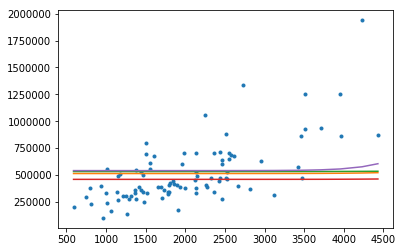

In [27]:
train_model_on_subsets(l2_large_penalty)

Play around with some of the l2 penalties and see what happens. 

## Ridge and LASSO Regression on Housing Data

Let's take a look at our dataset again.

In [28]:
sales

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront
6840700165,2014-07-01 00:00:00+00:00,202000,1,1.0,590,833,1.0,0
8122100392,2014-10-28 00:00:00+00:00,292500,2,1.0,750,5026,1.0,0
1222069089,2014-09-04 00:00:00+00:00,375000,1,1.0,800,533610,1.5,0
6450304630,2014-12-01 00:00:00+00:00,229000,2,1.0,810,5100,1.0,0
0148000450,2014-05-30 00:00:00+00:00,399000,2,1.0,940,4800,1.0,0
5128000010,2015-01-05 00:00:00+00:00,99000,2,1.0,960,8236,1.0,0
3679401110,2014-05-30 00:00:00+00:00,332000,2,1.0,1000,4776,1.0,0
1274500420,2014-09-09 00:00:00+00:00,234000,3,1.0,1010,8906,1.0,0
7171200445,2015-02-28 00:00:00+00:00,550700,2,1.0,1010,5000,1.5,0
1202000140,2014-12-10 00:00:00+00:00,160000,3,1.0,1060,8000,1.0,0


## Create new features

We are going to create new features that are transformations of our inputs.

In [29]:
from math import log, sqrt
sales['sqft_living_sqrt'] = sales['sqft_living'].apply(sqrt)
sales['sqft_lot_sqrt'] = sales['sqft_lot'].apply(sqrt)
sales['bedrooms_square'] = sales['bedrooms']*sales['bedrooms']
sales['floors_square'] = sales['floors']*sales['floors']

* Squaring bedrooms will increase the separation between not many bedrooms (e.g. 1) and lots of bedrooms (e.g. 4) since 1^2 = 1 but 4^2 = 16. Consequently this variable will mostly affect houses with many bedrooms.
* On the other hand, taking square root of sqft_living will decrease the separation between big house and small house. The owner may not be exactly twice as happy for getting a house that is twice as big.

In [30]:
all_features = ['bedrooms', 'bedrooms_square',
            'bathrooms',
            'sqft_living', 'sqft_living_sqrt',
            'sqft_lot', 'sqft_lot_sqrt',
            'floors', 'floors_square',
            'waterfront', 'view', 'condition', 'grade',
            'sqft_above',
            'sqft_basement',
            'yr_built', 'yr_renovated']

### Normalizing features

Here's a function that will take in a feature column and normalize it. We will apply this function on all of the features that we will be using.

In [31]:
def normalize(v):
    largest = v.max()
    if largest == 0: 
        return v
    return v / largest

In [32]:
for feature in all_features:
    sales[feature] = normalize(sales[feature])
    
sales

id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot
6840700165,2014-07-01 00:00:00+00:00,202000,0.166666666667,0.25,0.133182844244,0.00156106519743
8122100392,2014-10-28 00:00:00+00:00,292500,0.333333333333,0.25,0.169300225734,0.00941886396432
1222069089,2014-09-04 00:00:00+00:00,375000,0.166666666667,0.25,0.180586907449,1.0
6450304630,2014-12-01 00:00:00+00:00,229000,0.333333333333,0.25,0.182844243792,0.00955754202507
0148000450,2014-05-30 00:00:00+00:00,399000,0.333333333333,0.25,0.212189616253,0.00899533367066
5128000010,2015-01-05 00:00:00+00:00,99000,0.333333333333,0.25,0.216704288939,0.0154344933566
3679401110,2014-05-30 00:00:00+00:00,332000,0.333333333333,0.25,0.225733634312,0.00895035700231
1274500420,2014-09-09 00:00:00+00:00,234000,0.5,0.25,0.227990970655,0.0166900920148
7171200445,2015-02-28 00:00:00+00:00,550700,0.333333333333,0.25,0.227990970655,0.00937013924027
1202000140,2014-12-10 00:00:00+00:00,160000,0.5,0.25,0.23927765237,0.0149922227844


## Train, Test and Validation sets.

We stressed in lecture on the importance of splitting the data into training and test sets. We will also create a validation set from the training set which will allow us to explore multiple values for L1 and L2 penalties later on.

Let us do three way split into train, validation, and test sets:
* Split our sales data into 2 sets: training (90%) and test (10%)
* Further split our training data into two sets: train (50%), validation (50%)

**Be *very* careful that you use seed = 1 to ensure you get the same answer!**


Read the API for SFrames to figure out how to randomly split the data.
https://apple.github.io/turicreate/docs/api/generated/turicreate.SFrame.html

In [33]:
(training_and_validation, testing) = sales.random_split(0.9, seed = 1)
(training, validation) = training_and_validation.random_split(0.5, seed = 1)

Next, we write a loop that does the following:
* For `l2_penalty` in [10^-4, 10^-3, 10^-2, ..., 10^2] (to get this in Python, type `np.logspace(-3, 6, num=10)`.)
    * Fit a regression model with a given `l2_penalty` on TRAIN data. Specify `l2_penalty=l2_penalty` and `l1_penalty=0.` in the parameter list.
    * Evaluate the model on VALIDATION data (here you will want to use `.evaluate()`) for that `l2_penalty` and find the RMSE.
* Report which L2 penalty produced the lowest RMSE on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [34]:
l2_penalties = np.logspace(-4, 2, num=8)
rmse_all = []
ridge_models = []
minVal = None
minPenalty = None
for l2_penalty in l2_penalties:
    model = tc.linear_regression.create(training, target = 'price', features = all_features, l2_penalty = l2_penalty, l1_penalty = 0, validation_set = None, verbose = False)
    ridge_models.append(model)
    rmse = model.evaluate(validation).get('rmse')
    rmse_all.append(rmse)
l2_penalties[rmse_all.index(min(rmse_all))]






0.03727593720314938

### Q6) Run the code below to see which l2 penalty gave you the lowest RMSE. What was the l2 penalty?


In [35]:
ridge_models[rmse_all.index(min(rmse_all))].coefficients.print_rows(18)

+------------------+-------+----------------+--------+
|       name       | index |     value      | stderr |
+------------------+-------+----------------+--------+
|   (intercept)    |  None | 193705.726735  |  nan   |
|     bedrooms     |  None | -46358.0437739 |  nan   |
| bedrooms_square  |  None | -91718.9094554 |  nan   |
|    bathrooms     |  None | -42979.1699167 |  nan   |
|   sqft_living    |  None | 974874.789645  |  nan   |
| sqft_living_sqrt |  None | -1208131.9189  |  nan   |
|     sqft_lot     |  None | 1514956.37138  |  nan   |
|  sqft_lot_sqrt   |  None | -1433307.44098 |  nan   |
|      floors      |  None | 327861.849714  |  nan   |
|  floors_square   |  None | -302740.607443 |  nan   |
|    waterfront    |  None | 778105.922317  |  nan   |
|       view       |  None | -129183.449204 |  nan   |
|    condition     |  None | 168401.189304  |  nan   |
|      grade       |  None | 591010.840649  |  nan   |
|    sqft_above    |  None | 1084931.75091  |  nan   |
|  sqft_ba

Text(0,0.5,'RMSE')

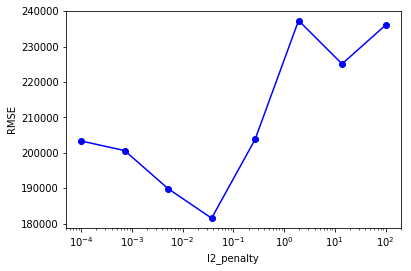

In [36]:
plt.plot(l2_penalties,rmse_all,'b-o')
plt.xscale('log')
plt.xlabel('l2_penalty')
plt.ylabel('RMSE')

### Q7) What is the RMSE on TEST data of the model with the best l2_penalty?

In [37]:
# We are extracting out the best penalty, and the model with that penalty.

best_l2_penalty = l2_penalties[rmse_all.index(min(rmse_all))]
best_ridge_model = ridge_models[rmse_all.index(min(rmse_all))]
test_rmse = best_ridge_model.evaluate(testing).get('rmse')
print('Best L2 Penalty', best_l2_penalty)
print('TEST RSME', test_rmse)

('Best L2 Penalty', 0.03727593720314938)
('TEST RSME', 132022.1745515674)


## LASSO Regression

Let's see a demonstration of LASSO regressions feature selection. Let's fit a model with a very high penalty of `l1_penalty=1e7`.

In [38]:
lasso_high_penalty = tc.linear_regression.create(training, target='price', features=all_features,
                                              validation_set=None,
                                              verbose=False,
                                              l2_penalty=0., l1_penalty=1e7)

### Q8) With this model, which features were not chosen?

Find what features had zero weights.

In [39]:
# We use print_rows(18) to print the 18 rows of the coefficient table 
# (by default, only 10 are printed) 
lasso_high_penalty.coefficients.print_rows(18)

+------------------+-------+---------------+--------+
|       name       | index |     value     | stderr |
+------------------+-------+---------------+--------+
|   (intercept)    |  None | 143278.292106 |  None  |
|     bedrooms     |  None |  27341.73657  |  None  |
| bedrooms_square  |  None | 31622.1132225 |  None  |
|    bathrooms     |  None | 86755.6989461 |  None  |
|   sqft_living    |  None | 120303.277231 |  None  |
| sqft_living_sqrt |  None | 54572.4599433 |  None  |
|     sqft_lot     |  None |      0.0      |  None  |
|  sqft_lot_sqrt   |  None |      0.0      |  None  |
|      floors      |  None |  35015.951987 |  None  |
|  floors_square   |  None | 43559.3023753 |  None  |
|    waterfront    |  None | 67290.4871043 |  None  |
|       view       |  None |      0.0      |  None  |
|    condition     |  None | 4459.87204552 |  None  |
|      grade       |  None | 41452.7472459 |  None  |
|    sqft_above    |  None | 110712.435741 |  None  |
|  sqft_basement   |  None |

## Learn the best L1 penalty

Let's go repeat the same process we followed for Ridge Regression to find the best `l1_penalty`.

***NOTE: Some things below have changed now***

Next, we write a loop that does the following:
* For `l1_penalty` in [10^5, 10^5.5, 10^6, 10^6.5, ..., 10^10] (to get this in Python, type `np.logspace(5, 10, num=10)`.)
    * Fit a regression model with a given `l1_penalty` on TRAIN data. Specify `l1_penalty=l1_penalty` and `l2_penalty=0.` in the parameter list.
    * Evaluate the model on VALIDATION data (here you will want to use `.evaluate()`) for that `l1_penalty` and find the RMSE.
* Report which L2 penalty produced the lowest RMSE on validation data.

When you call `linear_regression.create()` make sure you set `validation_set = None`.

Note: you can turn off the print out of `linear_regression.create()` with `verbose = False`

In [40]:
l1_penalties = np.logspace(5, 10, num=10)
rmse_all = []
lasso_models = []

for l1_penalty in l1_penalties:
    model = tc.linear_regression.create(training, target = 'price', features = all_features, l2_penalty = 0, l1_penalty = l1_penalty, validation_set = None, verbose = False)
    lasso_models.append(model)
    rmse = model.evaluate(validation).get('rmse')
    rmse_all.append(rmse)

### Q9) Run the code below to see which `l1 penalty` gave you the lowest RMSE. What was the `l1 penalty`?

In [41]:
l1_penalties[rmse_all.index(min(rmse_all))]

1291549.6650148828

Let's visualize this. We are using a log scale on our x axis.

Text(0,0.5,'RMSE')

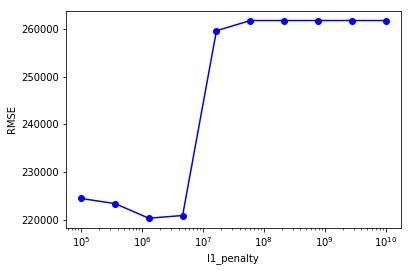

In [42]:
plt.plot(l1_penalties,rmse_all,'b-o')
plt.xscale('log')
plt.xlabel('l1_penalty')
plt.ylabel('RMSE')

### Q10) What is the RMSE on TEST data of the model with the best `l1_penalty`?

In [48]:
best_l1_penalty = l1_penalties[rmse_all.index(min(rmse_all))]
best_lasso_model = lasso_models[rmse_all.index(min(rmse_all))]
test_rmse = best_lasso_model.evaluate(testing).get('rmse')
print('Best L1 Penalty', best_l1_penalty)
print('TEST RSME', test_rmse)

('Best L1 Penalty', 1291549.6650148828)
('TEST RSME', 153086.95353792972)


### Q11) Now that we've trained a model with the best `l1_penalty`, which features were not chosen?

In [ ]:
coeff = best_lasso_model.coefficients
coeff.print_rows(18)

### Q12) Which did better? Ridge or LASSO?
a) Ridge regression  
b) LASSO

### Q13) Why would we want to use Ridge over Lasso?

Select all that apply:
* Feature Selection
* Usually gives lower true error
* Computationally more efficient.
* Usually gives lower test error
* Guaranteed to converge to the global optimum in all cases

### Q14) Why would we want to use Lasso over Ridge?

Select all that apply:
* Feature Selection
* Usually gives lower true error
* Computationally more efficient.
* Usually gives lower test error
* Guaranteed to converge to the global optimum in all cases